# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('')
%matplotlib inline

## Import the libraries

In [1]:
# Imports & config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:


# Safe seaborn theme (fallback to matplotlib default)
try:
    import seaborn as sns
    sns.set_theme()
except Exception:
    plt.style.use("default")

# Guard IPython magic (so cell is safe when run as a script)
try:
    get_ipython().run_line_magic("matplotlib", "inline")
except Exception:
    pass

# Paths
DATA_DIR = Path("../data/yfinance_data/Data/")
OUT_DIR = Path("../demo/figures/")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [6]:
# Fix notebook import/path + data dir (run first)
import sys
from pathlib import Path
import os

# Resolve repo root from the notebook location (notebooks/)
repo_root = Path.cwd().resolve().parent  # notebooks/ -> repo root
print("Repo root:", repo_root)

# Ensure repo root is on sys.path so `from scripts import ...` works
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
print("sys.path[0] (should be repo root):", sys.path[0])

# Correct data dir: your CSVs are in data/raw/yfinance_data/Data/
DATA_DIR = repo_root / "data" / "raw" / "yfinance_data" / "Data"
print("DATA_DIR ->", DATA_DIR)

# sanity checks
print("DATA_DIR exists?", DATA_DIR.exists())
print("List CSVs:", list(DATA_DIR.glob("*.csv"))[:10])

Repo root: C:\Users\My Device\Desktop\Week-1
sys.path[0] (should be repo root): C:\Users\My Device\Desktop\Week-1
DATA_DIR -> C:\Users\My Device\Desktop\Week-1\data\raw\yfinance_data\Data
DATA_DIR exists? True
List CSVs: [WindowsPath('C:/Users/My Device/Desktop/Week-1/data/raw/yfinance_data/Data/AAPL.csv'), WindowsPath('C:/Users/My Device/Desktop/Week-1/data/raw/yfinance_data/Data/AMZN.csv'), WindowsPath('C:/Users/My Device/Desktop/Week-1/data/raw/yfinance_data/Data/GOOG.csv'), WindowsPath('C:/Users/My Device/Desktop/Week-1/data/raw/yfinance_data/Data/META.csv'), WindowsPath('C:/Users/My Device/Desktop/Week-1/data/raw/yfinance_data/Data/MSFT.csv'), WindowsPath('C:/Users/My Device/Desktop/Week-1/data/raw/yfinance_data/Data/NVDA.csv')]


### Data Loading

Load CSVs (expected columns: Date, Open, High, Low, Close, Volume). The helper `scripts/analysis.py` is preferred (it reads all CSVs and adds a `Symbol` column).

In [7]:
from scripts.analysis import load_yfinance_data

all_df = load_yfinance_data(str(DATA_DIR))   # loads all csvs and sets 'Symbol'
TICKER = "AAPL"
symbol_df = all_df[all_df["Symbol"] == TICKER].reset_index(drop=True)
symbol_df.head()

,Date,Close,High,Low,Open,Volume,Symbol
0,2009-01-02,2.721686,2.730385,2.554037,2.575630,746015200,AAPL
1,2009-01-05,2.836553,2.884539,2.780469,2.794266,1181608400,AAPL
2,2009-01-06,2.789767,2.914229,2.770872,2.877641,1289310400,AAPL
3,2009-01-07,2.729484,2.774170,2.706990,2.753477,753048800,AAPL
4,2009-01-08,2.780169,2.793666,2.700393,2.712090,673500800,AAPL


### Compute Indicators

Prefer `compute_indicators` from `scripts/analysis.py` (uses TA-Lib when installed). If not available, compute SMA/EMA/RSI/MACD locally (fallback).

In [8]:
try:
    from scripts.analysis import compute_indicators
    ind_df = compute_indicators(symbol_df)
except Exception:
    # Local fallbacks
    ind_df = symbol_df.copy()
    ind_df["SMA_20"] = ind_df["Close"].rolling(window=20).mean()
    ind_df["EMA_20"] = ind_df["Close"].ewm(span=20, adjust=False).mean()
    delta = ind_df["Close"].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    ma_up = up.rolling(14).mean()
    ma_down = down.rolling(14).mean()
    rs = ma_up / ma_down
    ind_df["RSI_14"] = 100 - (100 / (1 + rs))
    ema12 = ind_df["Close"].ewm(span=12, adjust=False).mean()
    ema26 = ind_df["Close"].ewm(span=26, adjust=False).mean()
    ind_df["MACD"] = ema12 - ema26
    ind_df["MACD_signal"] = ind_df["MACD"].ewm(span=9, adjust=False).mean()

ind_df.head()

,Date,Close,High,Low,Open,Volume,Symbol,SMA_20,EMA_20,RSI_14,MACD,MACD_signal
0,2009-01-02,2.721686,2.730385,2.554037,2.575630,746015200,AAPL,2.721686,2.721686,NaN,0.000000,0.000000
1,2009-01-05,2.836553,2.884539,2.780469,2.794266,1181608400,AAPL,2.779120,2.732626,NaN,0.009163,0.001833
2,2009-01-06,2.789767,2.914229,2.770872,2.877641,1289310400,AAPL,2.782669,2.738068,NaN,0.012506,0.003967
3,2009-01-07,2.729484,2.774170,2.706990,2.753477,753048800,AAPL,2.769372,2.737250,NaN,0.010173,0.005208
4,2009-01-08,2.780169,2.793666,2.700393,2.712090,673500800,AAPL,2.771532,2.741338,NaN,0.012273,0.006621


### Price with SMA and EMA

Plot close price overlaid with SMA(20) and EMA(20).

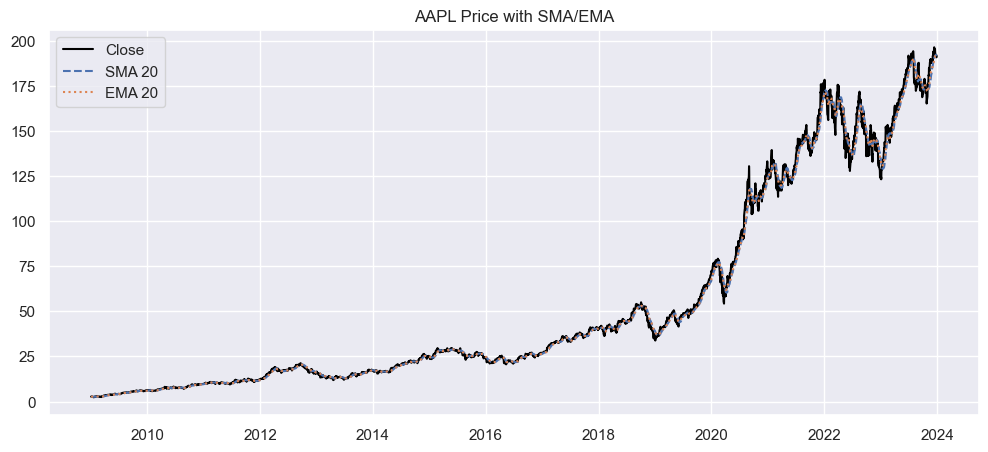

In [9]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(ind_df["Date"], ind_df["Close"], label="Close", color="black")
if "SMA_20" in ind_df:
    ax.plot(ind_df["Date"], ind_df["SMA_20"], label="SMA 20", linestyle="--")
if "EMA_20" in ind_df:
    ax.plot(ind_df["Date"], ind_df["EMA_20"], label="EMA 20", linestyle=":")
ax.set_title(f"{TICKER} Price with SMA/EMA")
ax.legend(); ax.grid(True)
fig.savefig(OUT_DIR / f"{TICKER}_price_sma_ema.png", bbox_inches="tight")
plt.show()

### RSI Panel

Plot price above and RSI (14) below (show overbought/oversold at 70/30).

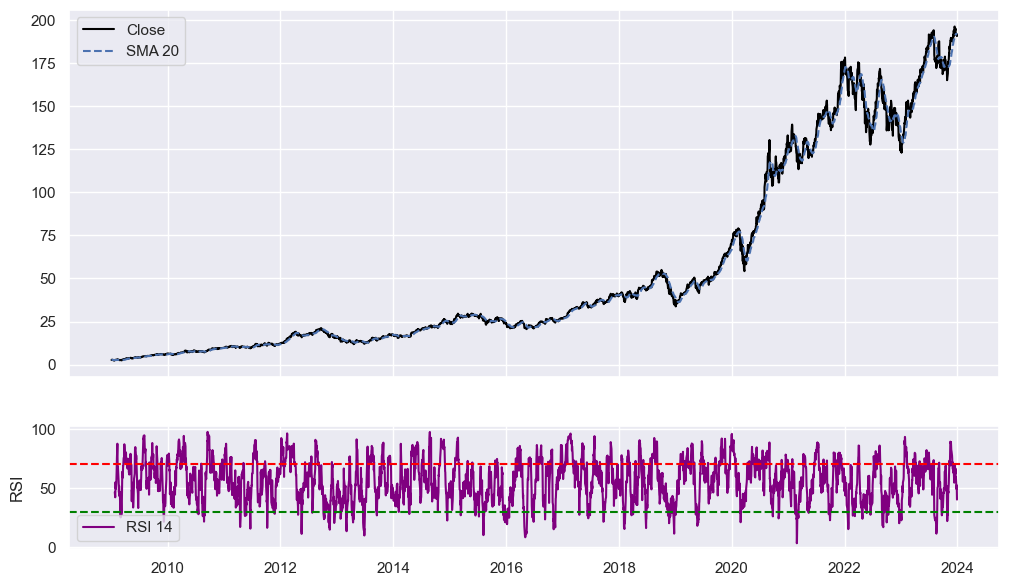

In [10]:
fig, (ax_price, ax_rsi) = plt.subplots(2,1, figsize=(12,7), sharex=True,
                                       gridspec_kw={"height_ratios":[3,1]})
ax_price.plot(ind_df["Date"], ind_df["Close"], color="black", label="Close")
if "SMA_20" in ind_df:
    ax_price.plot(ind_df["Date"], ind_df["SMA_20"], label="SMA 20", linestyle="--")
ax_price.legend(); ax_price.grid(True)

if "RSI_14" in ind_df:
    ax_rsi.plot(ind_df["Date"], ind_df["RSI_14"], color="purple", label="RSI 14")
    ax_rsi.axhline(70, color="red", linestyle="--")
    ax_rsi.axhline(30, color="green", linestyle="--")
    ax_rsi.set_ylabel("RSI")
    ax_rsi.legend()
fig.savefig(OUT_DIR / f"{TICKER}_price_rsi.png", bbox_inches="tight")
plt.show()

### MACD Panel

Plot price and MACD with signal line below; zero line helps spot crossovers.

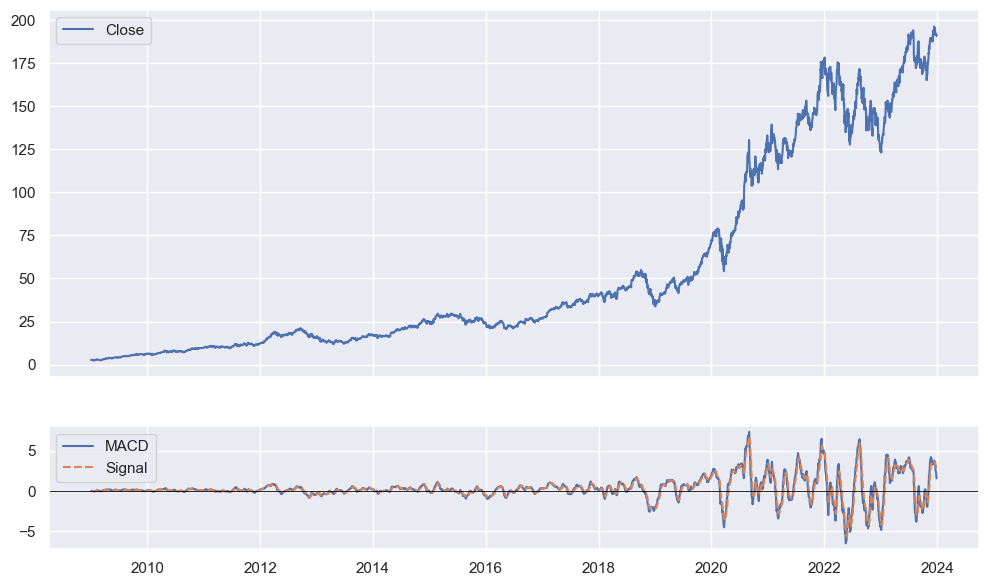

In [11]:
fig, (ax_top, ax_macd) = plt.subplots(2,1, figsize=(12,7), sharex=True,
                                      gridspec_kw={"height_ratios":[3,1]})
ax_top.plot(ind_df["Date"], ind_df["Close"], label="Close")
ax_top.legend(); ax_top.grid(True)

if "MACD" in ind_df:
    ax_macd.plot(ind_df["Date"], ind_df["MACD"], label="MACD")
    ax_macd.plot(ind_df["Date"], ind_df["MACD_signal"], label="Signal", linestyle="--")
    ax_macd.axhline(0, color="black", linewidth=0.6)
    ax_macd.legend()
fig.savefig(OUT_DIR / f"{TICKER}_macd.png", bbox_inches="tight")
plt.show()

### Candlestick + Volume (mplfinance)

Use `mplfinance` for professional candlestick charts with volume. Install: `pip install mplfinance` (or `conda`).

In [12]:
# Optional: candlestick with volume
try:
    import mplfinance as mpf
    mpf_df = ind_df.set_index("Date")[["Open","High","Low","Close","Volume"]].copy()
    mpf.plot(mpf_df.tail(200), type="candle", volume=True, style="yahoo",
             title=f"{TICKER} Candlestick (recent 200 days)",
             savefig=str(OUT_DIR / f"{TICKER}_candlestick.png"))
except Exception as e:
    print("mplfinance not available:", e)

mplfinance not available: No module named 'mplfinance'


### Interactive Plotly Candlestick + EMA (optional)

Plotly allows zoom/hover. Install: `pip install plotly`.

In [13]:
try:
    import plotly.graph_objects as go
    fig = go.Figure()
    fig.add_trace(go.Candlestick(x=ind_df["Date"],
                                 open=ind_df["Open"], high=ind_df["High"],
                                 low=ind_df["Low"], close=ind_df["Close"],
                                 name="candlestick"))
    if "EMA_20" in ind_df:
        fig.add_trace(go.Scatter(x=ind_df["Date"], y=ind_df["EMA_20"], name="EMA20"))
    fig.update_layout(title=f"{TICKER} Interactive Candlestick + EMA20")
    fig.show()
except Exception as e:
    print("plotly not available or failed:", e)

### Risk & Distribution Visuals

Histogram of daily returns, rolling volatility (30-day), and cumulative drawdown show risk characteristics.

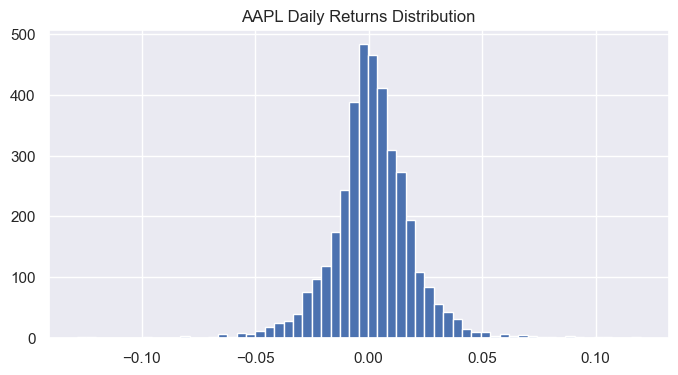

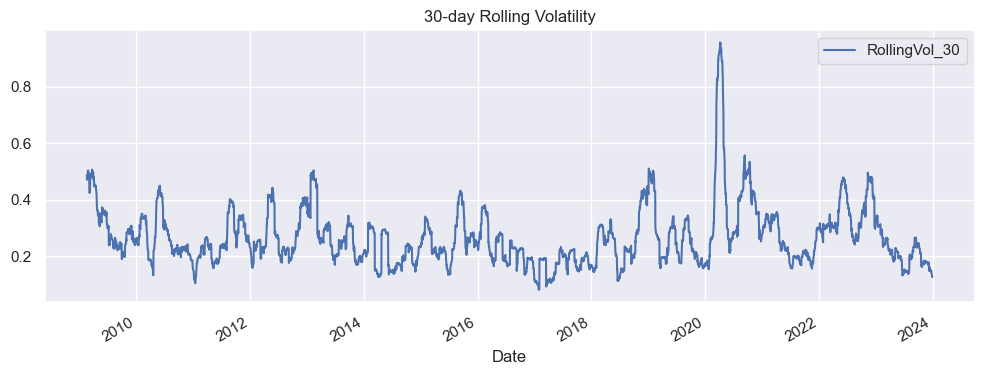

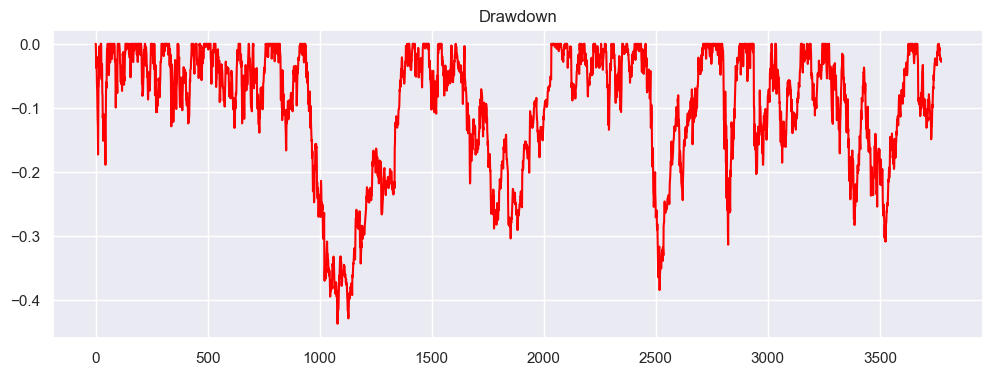

In [14]:
ind_df["Return"] = ind_df["Close"].pct_change()

# Returns histogram
fig = plt.figure(figsize=(8,4))
ind_df["Return"].dropna().hist(bins=60)
plt.title(f"{TICKER} Daily Returns Distribution")
plt.savefig(OUT_DIR / f"{TICKER}_returns_hist.png", bbox_inches="tight")
plt.show()

# Rolling volatility
ind_df["RollingVol_30"] = ind_df["Return"].rolling(30).std() * np.sqrt(252)
ind_df.plot(x="Date", y="RollingVol_30", figsize=(12,4), title="30-day Rolling Volatility")
plt.savefig(OUT_DIR / f"{TICKER}_rolling_vol.png", bbox_inches="tight")
plt.show()

# Drawdown
cum = (1 + ind_df["Return"].fillna(0)).cumprod()
peak = cum.cummax()
drawdown = (cum - peak) / peak
drawdown.plot(figsize=(12,4), color="red", title="Drawdown")
plt.savefig(OUT_DIR / f"{TICKER}_drawdown.png", bbox_inches="tight")
plt.show()

### Indicator Correlation

Correlation heatmap helps detect redundant or collinear indicators.

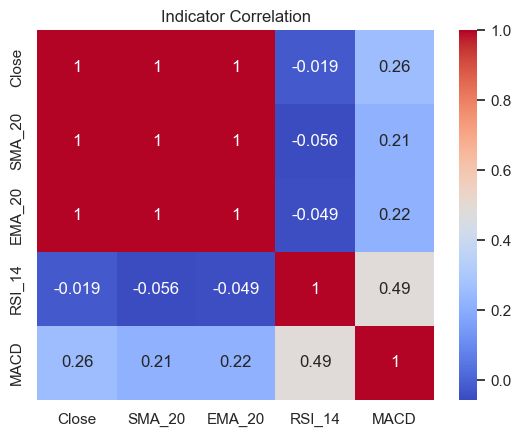

In [15]:
try:
    import seaborn as sns
    corr_cols = ["Close","SMA_20","EMA_20","RSI_14","MACD"]
    sns.heatmap(ind_df[corr_cols].dropna().corr(), annot=True, cmap="coolwarm")
    plt.title("Indicator Correlation")
    plt.savefig(OUT_DIR / f"{TICKER}_corr_heatmap.png", bbox_inches="tight")
    plt.show()
except Exception as e:
    print("Seaborn not available or heatmap failed:", e)

### How to run & dependency notes

- Recommended install (Windows, prefer conda for TA-Lib):
  - `conda install -c conda-forge ta-lib seaborn matplotlib pandas numpy mplfinance plotly`
  - `pip install pynance`
- Or use pip for pure-Python: `pip install -r requirements.txt`.
- If TA-Lib is not available the notebook uses pandas fallbacks, but verify numerical results.
- Save figures are written to `demo/figures/`.

In [16]:
# Optional: call the script to reproduce full analysis across all symbols
try:
    import importlib
    from scripts import analysis
    importlib.reload(analysis)
    analysis.main(data_dir=str(DATA_DIR), out_folder=str(OUT_DIR))
except Exception as e:
    print("Could not run scripts/analysis.main():", e)

Loading data from C:\Users\My Device\Desktop\Week-1\data\raw\yfinance_data\Data
Loaded 21793 rows for 6 symbols
Computed indicators and financial metrics:
   Symbol  Annualized Return  Annualized Volatility  Sharpe Ratio (approx)  \
0   AAPL           0.383541               0.285902               1.341515   
1   AMZN           0.388236               0.346528               1.120360   
2   GOOG           0.257668               0.275161               0.936425   
3   META           0.313224               0.401306               0.780511   
4   MSFT           0.285005               0.268038               1.063302   
5   NVDA           0.604070               0.459048               1.315919   

   Observations  
0          3774  
1          3774  
2          3774  
3          2923  
4          3774  
5          3774  
Saved 6 figures to ..\demo\figures
